In [1]:
!git clone https://mszarski:{}@github.com/mszarski/flatmesh

Cloning into 'flatmesh'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 4), reused 23 (delta 3), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [2]:
!apt install libeigen3-dev
!ln -sf /usr/include/eigen3/Eigen /usr/include/Eigen

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libeigen3-doc libmrpt-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 810 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeigen3-dev all 3.3.4-4 [810 kB]
Fetched 810 kB in 1s (643 kB/s)
Selecting previously unselected package libeigen3-dev.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.3.4-4_all.deb ...
Unpacking libeigen3-dev (3.3.4-4) ...
Setting up libeigen3-dev (3.3.4-4) ...


In [3]:
!pip install ./flatmesh

Processing ./flatmesh
  Created wheel for flatmesh: filename=flatmesh-0.0.1-cp36-cp36m-linux_x86_64.whl size=5740181 sha256=3612884d11e3395e8f5dc6c1a79ef52eba97d7c09e614eed8ea043d74549279b
  Stored in directory: /tmp/pip-ephem-wheel-cache-sqjqpw8y/wheels/e2/ce/d5/e541f72b10062c7b5699690828825b335938ca92f396cb0fff
Successfully built flatmesh


In [4]:
!pip install trimesh

     |████████████████████████████████| 634kB 8.0MB/s 


In [5]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [6]:
import trimesh
import numpy as np
from scipy.spatial import distance
import flatmesh
import matplotlib.pyplot as plt

In [29]:
curved_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/3d_shape.obj',process=False)

In [8]:
curved_mesh.show()

In [72]:
v = curved_mesh.vertices
f = curved_mesh.faces

# p0 = 0
# distances = distance.cdist(v, [v[p0]], 'euclidean')
# p1 = distances.argmax()
# dist = distances[p1][0]

p0 = 83
p1 = 11 #central line

flattener = flatmesh.FaceUnwrapper(v, f)
flattener.findFlatNodes(5, 0.99)
uv = flattener.ze_nodes

In [73]:
flat_vertices = np.vstack((uv[:,0], uv[:,1], np.zeros_like(uv[:,1]))).T

In [74]:
#align mesh constant seam in xy plane
v_flat = flat_vertices[p1] - flat_vertices[p0]
v_curved = v[p1] - v[p0]
v_curved[2] = 0.0
T, a = trimesh.geometry.align_vectors(v_curved, v_flat, return_angle=True)
flat_vertices = trimesh.transformations.transform_points(flat_vertices,T)

In [75]:
flat_mesh = trimesh.Trimesh(vertices=flat_vertices,
                       faces=curved_mesh.faces,
                       process=False)

In [76]:
com_delta = curved_mesh.centroid - flat_mesh.centroid
com_delta[2] = 0
flat_mesh.vertices = flat_mesh.vertices + com_delta

In [77]:
flat_mesh.invert()

In [78]:
flat_mesh.show()

In [79]:
trimesh.repair.fix_normals(flat_mesh)

In [80]:
scene = trimesh.Scene([curved_mesh, flat_mesh])
scene.show(viewer='notebook')

In [83]:
flat_mesh.export('/content/drive/My Drive/draping_workspace/2d_shape_flatmesh.obj')

'# https://github.com/mikedh/trimesh\nv 91.57049771 -172.69303374 0.00000000\nv 83.05072748 -178.89356021 0.00000000\nv 92.31209385 -183.29774446 0.00000000\nv 80.61106362 167.09811457 0.00000000\nv 60.63952532 174.05268382 0.00000000\nv 53.66333730 155.21002798 0.00000000\nv 70.61210471 151.29756793 0.00000000\nv 41.26575550 178.96301405 0.00000000\nv 35.86724675 156.85344142 0.00000000\nv 20.85058707 182.20512307 0.00000000\nv 17.03680732 158.77334099 0.00000000\nv 0.45961876 183.45772222 0.00000000\nv -2.27717405 159.67355772 0.00000000\nv -21.90642428 182.53446598 0.00000000\nv -21.95129182 158.89160560 0.00000000\nv -41.62193377 179.70886406 0.00000000\nv -41.03927871 156.35281488 0.00000000\nv -61.97665986 174.77276251 0.00000000\nv -59.64967746 152.20074613 0.00000000\nv -81.07177139 168.22107453 0.00000000\nv -77.09474760 146.84942087 0.00000000\nv -99.15077902 160.24976155 0.00000000\nv -93.46833923 140.69384082 0.00000000\nv -115.56066451 151.47449843 0.00000000\nv -108.95292

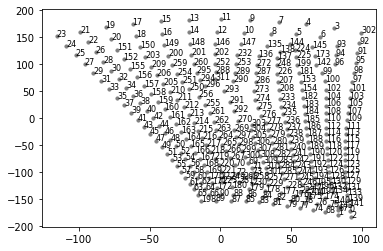

In [81]:
plt.scatter(flat_mesh.vertices[:,0],flat_mesh.vertices[:,1],c='grey',s=10)
for i in range(flat_mesh.vertices.shape[0]):
    plt.text(flat_mesh.vertices[i,0], flat_mesh.vertices[i,1], str(i),fontsize=8)

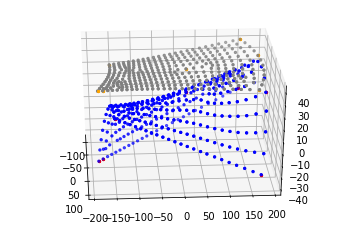

In [82]:
seed_point_index = 292
handles = [302, 198, 2, 23]
flattening_line = [0,15]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

from IPython.display import HTML
import matplotlib.animation as animation

def init():
    ax.scatter(flat_mesh.vertices[:,0],flat_mesh.vertices[:,1],flat_mesh.vertices[:,2]+40,c='grey',s=5)
    ax.scatter(curved_mesh.vertices[:,0],curved_mesh.vertices[:,1],curved_mesh.vertices[:,2],c='blue',s=5)
    for i in [seed_point_index, *handles, *flattening_line]:
        ax.scatter(flat_mesh.vertices[i,0],flat_mesh.vertices[i,1],flat_mesh.vertices[i,2]+40,c='orange',s=5)
        ax.scatter(curved_mesh.vertices[i,0],curved_mesh.vertices[i,1],curved_mesh.vertices[i,2],c='red',s=5)
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)    

HTML(ani.to_html5_video())